In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
#Import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape , test.shape 

((1460, 81), (1459, 80))

In [3]:
#EDA
train.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1256,1257,20,RL,91.0,14303,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,301500
955,956,90,RH,82.0,7136,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,145000
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000
422,423,20,RL,100.0,21750,Pave,NaN,Reg,HLS,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,113000
1144,1145,190,RL,60.0,12180,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2010,WD,Normal,80000
723,724,50,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,135000
278,279,20,RL,107.0,14450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,New,Partial,415298
834,835,20,RL,75.0,7875,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,9,2008,WD,Normal,139950
468,469,20,RL,98.0,11428,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,250000
354,355,50,RL,60.0,8400,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,140000


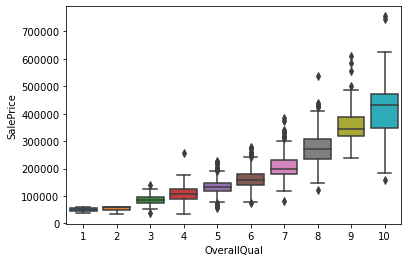

In [4]:
# overall quality 
ax = sns.boxplot(x="OverallQual", y="SalePrice", data=train)

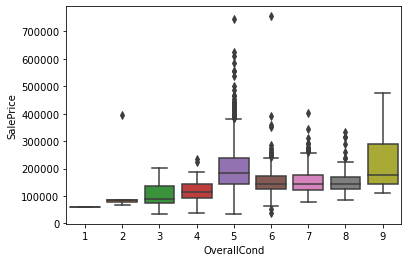

In [5]:
# Overall Condition
ax = sns.boxplot(x="OverallCond", y="SalePrice", data=train)

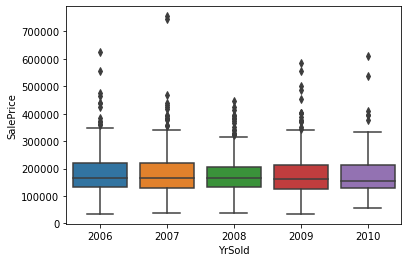

In [6]:
#Year Sold
ax = sns.boxplot(x="YrSold", y="SalePrice", data=train)

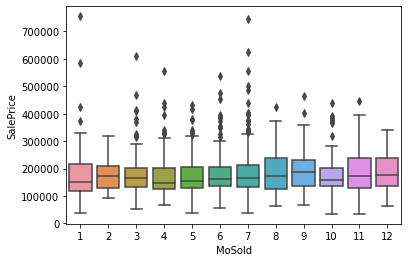

In [7]:
ax = sns.boxplot(x="MoSold", y="SalePrice", data=train)
#It looks like there is very little pricing seasonality

Text(0.5, 1.0, 'Sale Price by Month and Year')

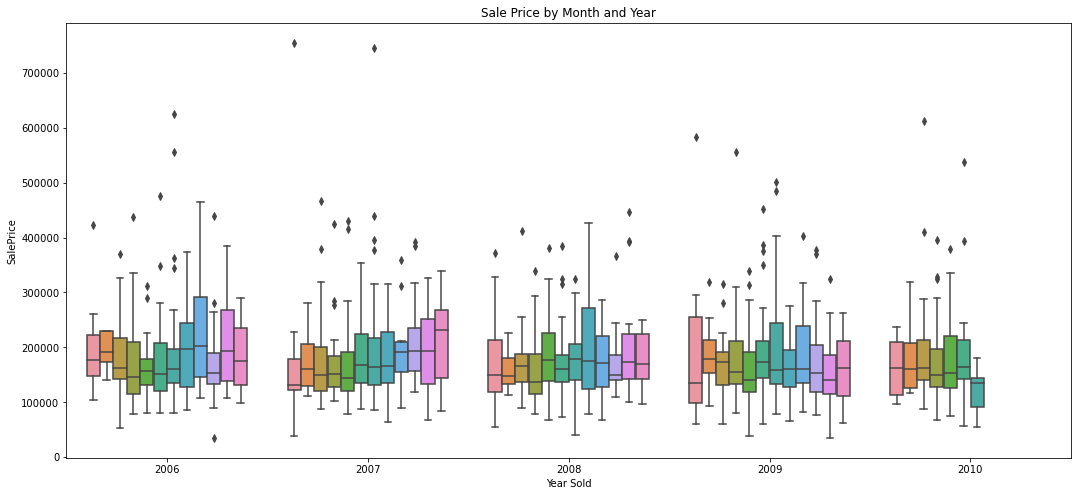

In [8]:
#Month Sold
plt.figure(figsize=(18,8))
ax = sns.boxplot(x="YrSold", y="SalePrice", hue="MoSold", data=train)
ax.legend_.remove()
ax.set_xlabel('Year Sold')
ax.set_title('Sale Price by Month and Year')
#Aside from prices diving in December 2010, there is surprisingly little seasonality in Sale Prices

Text(0.5, 1.0, 'Sale Price of Different Quality Houses by Year')

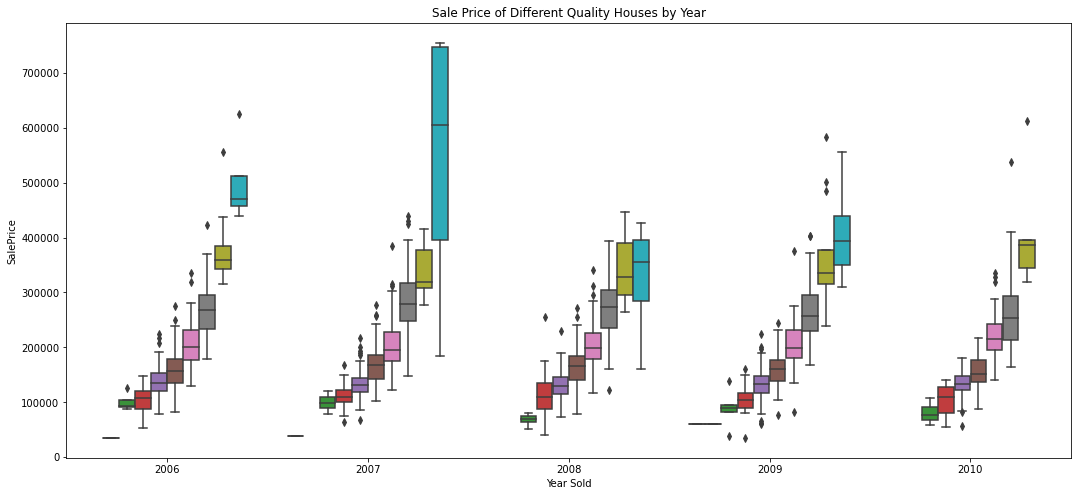

In [9]:
#Did houses of the same quality get priced differently throughout the years?
plt.figure(figsize=(18,8))
ax = sns.boxplot(x="YrSold", y="SalePrice", hue="OverallQual", data=train)
ax.legend_.remove()
ax.set_xlabel('Year Sold')
ax.set_title('Sale Price of Different Quality Houses by Year')

In [10]:
#Save the 'Id' column and remove from train and test sets
train_ID = train['Id']
test_ID = test['Id']

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape , test.shape

((1460, 80), (1459, 79))

Text(0.5, 1.0, 'Features Correlating with Sale Price')

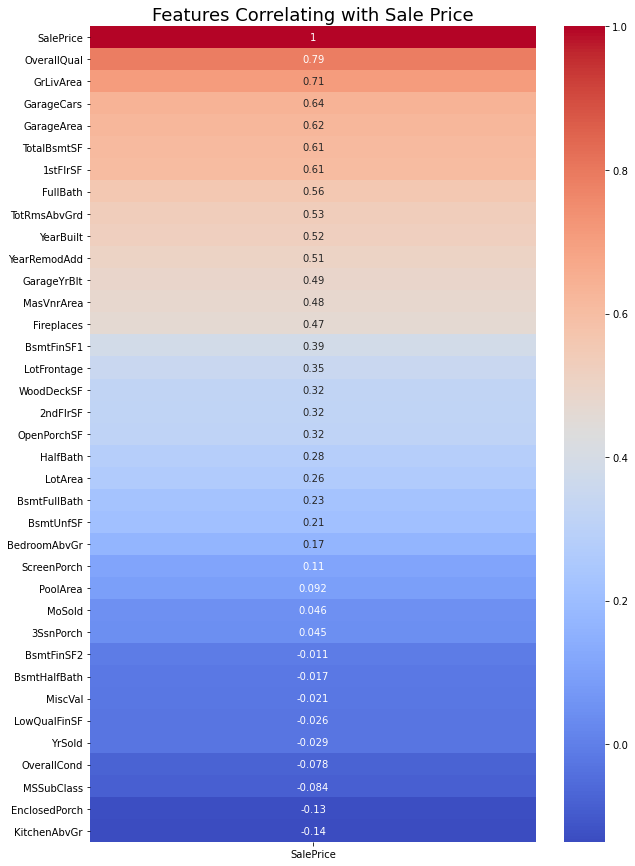

In [11]:
#Heatmap of variables with the highest correlation to sale price
plt.figure(figsize=(10,15))
sns.heatmap(train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False),
            annot=True, cmap='coolwarm').set_title('Features Correlating with Sale Price', fontdict={'fontsize':18})

Text(0.5, 1.0, 'Correlation Heatmap')

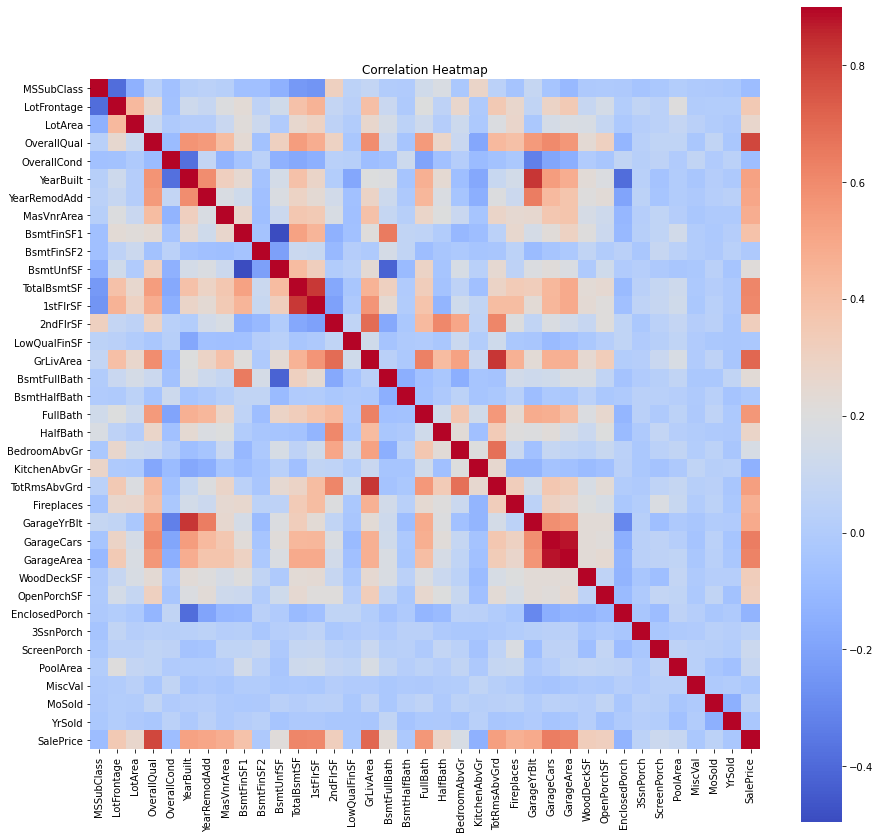

In [12]:
#heatmap to get a sense of correlations
plt.figure(figsize=(15,15))
ax=sns.heatmap(train.corr(), vmax=0.9, square=True, cmap='coolwarm')
ax.set_title('Correlation Heatmap')

- GarageCars seems perfectly correlated with GarageArea, so we can drop GarageCars
- YearBuilt is highly correlated with GarageYrBuilt, which is also correlated with YearRemodAdd, so we can drop GarageYrBuilt
- GrLivArea is highly correlated with TotRmsAbvGrd, we can drop TotRmsAbvGrd
- TotalBsmtSF is highly correlated with 1stFlSF, and since we have this variable we can drop BsmtUnfSF, BsmtFinSF1, BsmtFinSF2
- BsmtFinSF1 is correlated with BsmtFullBath
- We will also drop 1stFlrSF & 2ndFlrSF since this will be expressed in GrLivArea

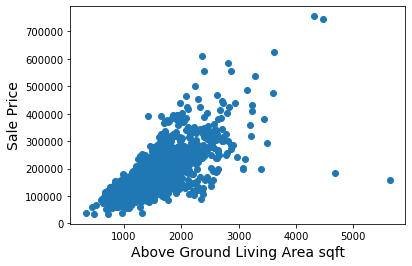

In [13]:
#Data Cleaning

#Plot sale price against GrLivArea
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('Sale Price', fontsize=14)
plt.xlabel('Above Ground Living Area sqft', fontsize=14)
plt.show()

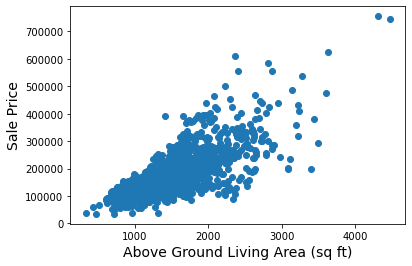

In [14]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index)
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('Sale Price', fontsize=14)
plt.xlabel('Above Ground Living Area (sq ft)', fontsize=14)
plt.show()

Text(0.5, 1.0, 'Sale Price Distribution')

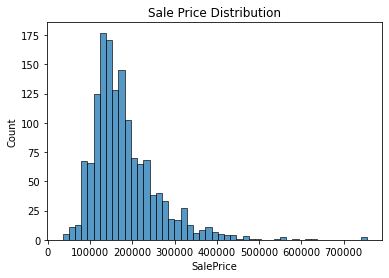

In [15]:
#Plot sale price
sns.histplot(train['SalePrice']).set_title('Sale Price Distribution')

#The plot shows a right skew- we will apply a log transformation to normalize the distribution

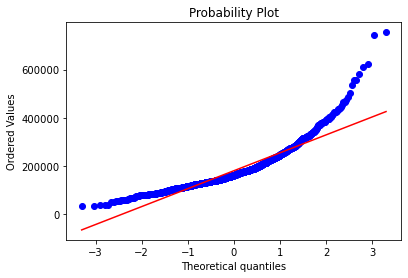

In [16]:
#QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

[Text(0.5, 0, 'Log SalePrice')]

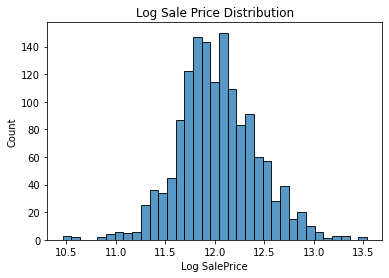

In [17]:
#Apply log transformation to sale price
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
ax=sns.histplot(train['SalePrice'])
plt.title('Log Sale Price Distribution')
ax.set(xlabel="Log SalePrice")

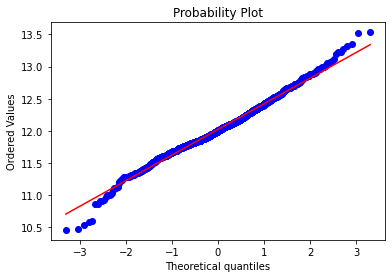

In [18]:
#QQ-plot after log transformation
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [19]:
#Create a combined dataset
combined = pd.concat([train,test], axis=0, sort=False)
combined.drop(['SalePrice'], axis=1, inplace=True)

#Drop redundant/unnecessary columns
combined = combined.drop(columns=['GarageCars','GarageYrBlt','TotRmsAbvGrd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                                 '1stFlrSF','2ndFlrSF','Utilities'])
    #note all values of Utilities are the same except for 1 in train set
combined.shape

(2917, 70)

In [20]:
#Missing values
combined_na = (combined.isnull().sum() / len(combined)).sort_values(ascending=False)

na_ratios = pd.DataFrame({'Ratio of Missing Values' :combined_na})

#Show all columns that contain missing values
na_ratios[na_ratios['Ratio of Missing Values']>0]

,Ratio of Missing Values
PoolQC,0.996915
MiscFeature,0.964004
Alley,0.932122
Fence,0.804251
FireplaceQu,0.486802
LotFrontage,0.166610
GarageQual,0.054508
GarageFinish,0.054508
GarageCond,0.054508
GarageType,0.053822


In [21]:
#Fill NAs as "None" where appropriate based on documentation
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']

combined[none_cols] = combined[none_cols].fillna('None')

#Fill zeros for numerical NAs
zero_cols = ['GarageArea','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea']

combined[zero_cols]=combined[zero_cols].fillna(0)

In [22]:
#Lot Frontage: does this correlate to Lot Area? It the correlation is high, we will drop LotFrontage
from scipy.stats import pearsonr
lot_compare = combined[combined['LotFrontage'].notna()]

corr, _ = pearsonr(lot_compare['LotFrontage'], lot_compare['LotArea'])
print('Pearsons correlation of lot area and lot frontage: %.3f' % corr)

Pearsons correlation of lot area and lot frontage: 0.469


In [23]:
#Impute median neighhborhood LotFrontage instead of dropping it
#LotFrontage could affect the home's visual appeal which is difficult to quantify
combined['LotFrontage'] = combined.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
#Check for remaining LotFrontage missingness
combined['LotFrontage'].isnull().sum()

0

In [24]:
#Impute mode for categorical missing values
combined['MSZoning'] = combined['MSZoning'].fillna(combined['MSZoning'].mode()[0])
combined['Electrical'] = combined['Electrical'].fillna(combined['Electrical'].mode()[0])
combined['KitchenQual'] = combined['KitchenQual'].fillna(combined['KitchenQual'].mode()[0])
combined['Exterior1st'] = combined['Exterior1st'].fillna(combined['Exterior1st'].mode()[0])
combined['Exterior2nd'] = combined['Exterior2nd'].fillna(combined['Exterior2nd'].mode()[0])
combined['SaleType'] = combined['SaleType'].fillna(combined['SaleType'].mode()[0])
combined['Functional'] = combined['Functional'].fillna(combined['Functional'].mode()[0])

In [25]:
#Converting numeric variables that are actually categorical

#Converting MSSubClass and Month Sold
combined['MSSubClass']=combined['MSSubClass'].astype("str")
combined['MoSold']=combined['MoSold'].astype("str")

combined.MSSubClass.dtype

dtype('O')

In [34]:
#Feature Engineering

#house age
combined['HouseAge']= combined['YrSold']-combined['YearBuilt']
combined['HouseAge'] = np.where(combined['HouseAge']<0, 0, combined['HouseAge'])

#years since remodel
combined['YrsSinceRemod']= combined['YrSold']-combined['YearRemodAdd']

#total bathrooms
combined['Bathrooms']= combined['FullBath']+(combined['HalfBath']*.5)+combined['BsmtFullBath']+(combined['BsmtHalfBath']*.5)

#total porch sq ft
combined['PorchSF']= combined['OpenPorchSF']+combined['EnclosedPorch']+combined['3SsnPorch']+combined['ScreenPorch']

In [38]:
#Drop columns used in calculating new columns
combined = combined.drop(columns=['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath',
                                 'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
                                 'YearBuilt','YearRemodAdd'])

#Convert YrSold to Category
combined['YrSold']=combined['YrSold'].astype("str")

In [39]:
#Identify variables with high skew levels
skewed = combined.select_dtypes(exclude=['object']).skew(axis=0).sort_values(ascending=False)

high_skew = skewed[abs(skewed) > 0.5]
high_skew

MiscVal         21.950962
PoolArea        17.697766
LotArea         13.116240
LowQualFinSF    12.090757
KitchenAbvGr     4.302763
MasVnrArea       2.623068
PorchSF          2.245655
WoodDeckSF       1.845741
LotFrontage      1.103606
GrLivArea        1.069300
Fireplaces       0.725651
TotalBsmtSF      0.672097
HouseAge         0.598364
OverallCond      0.569607
dtype: float64

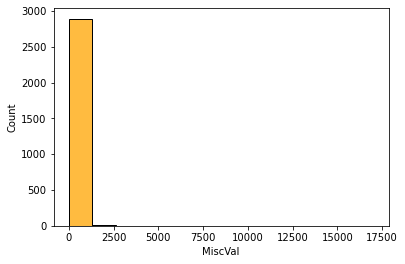

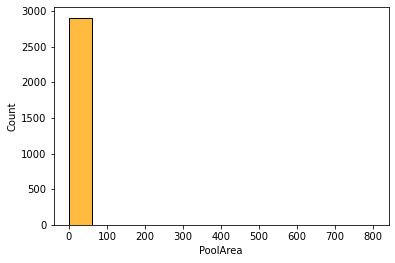

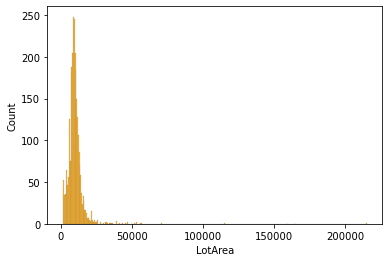

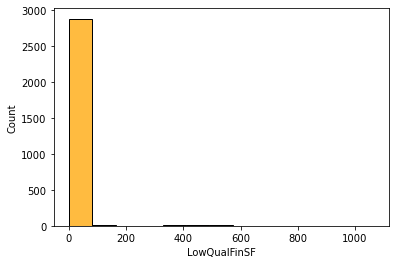

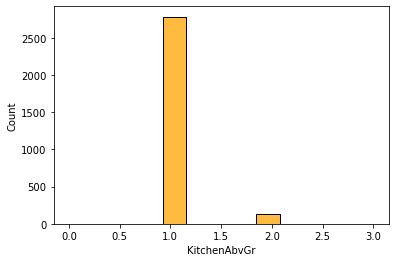

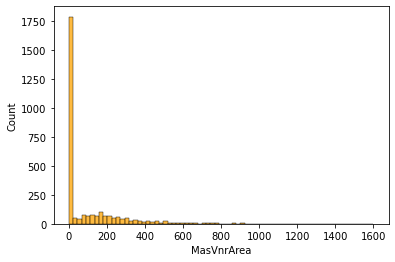

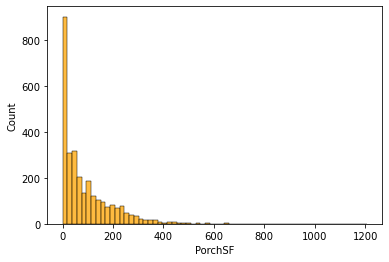

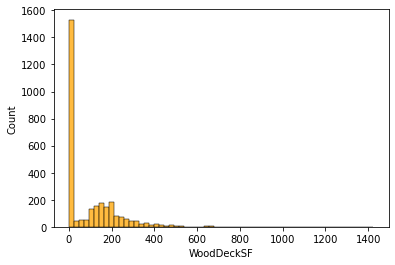

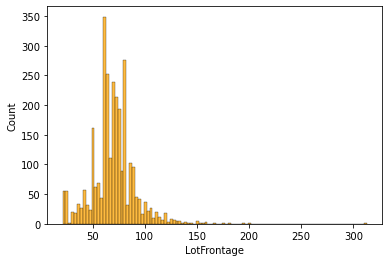

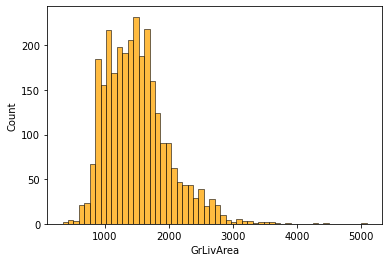

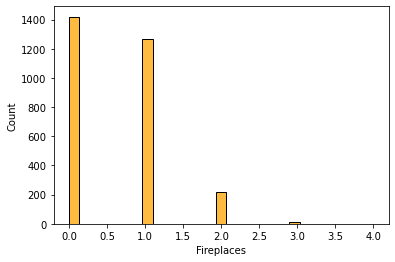

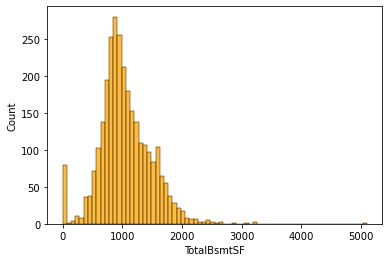

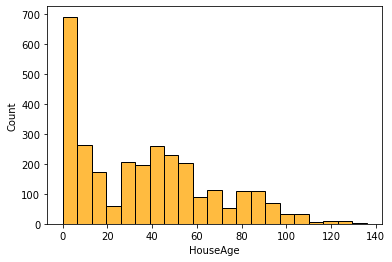

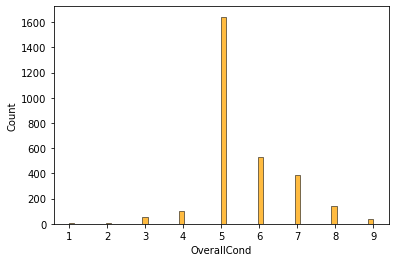

In [40]:
#Visualizing the skewed variables
skew_plt = list(high_skew.index)
for i in skew_plt:    
    fig, ax=plt.subplots()
    sns.histplot(combined[i], color='orange')

In [41]:
#drop LowQualFinSF(vast majority of values are zero), PoolArea(this is somewhat redundant with PoolQuality)
combined = combined.drop(columns=['LowQualFinSF','PoolArea'])
#re-run skew
skewed = combined.select_dtypes(exclude=['object']).skew(axis=0).sort_values(ascending=False)
high_skew = skewed[skewed > 0.5]
high_skew

MiscVal         21.950962
LotArea         13.116240
KitchenAbvGr     4.302763
MasVnrArea       2.623068
PorchSF          2.245655
WoodDeckSF       1.845741
LotFrontage      1.103606
GrLivArea        1.069300
Fireplaces       0.725651
TotalBsmtSF      0.672097
HouseAge         0.598364
OverallCond      0.569607
dtype: float64

In [42]:
#Log transformation of skewed numerical features
np.seterr(divide = 'ignore') 

for col in high_skew.index:
    combined[col] = np.log1p(combined[col])

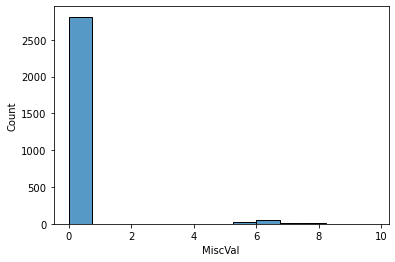

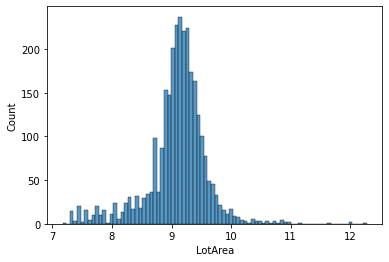

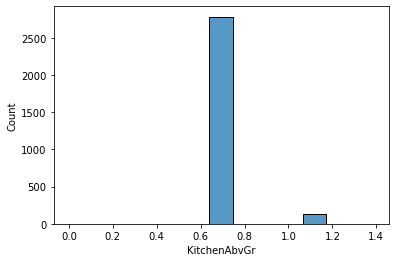

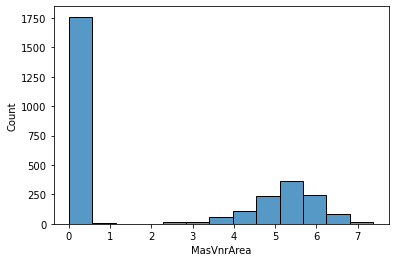

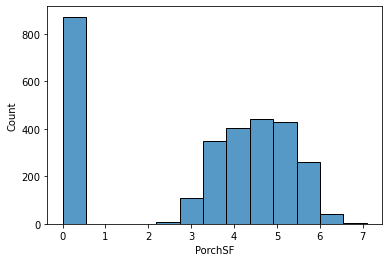

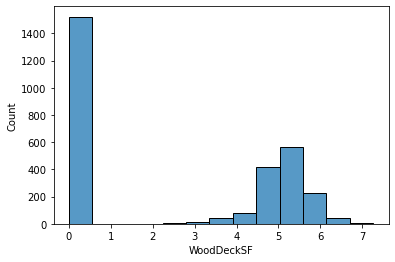

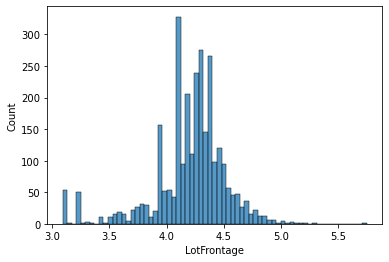

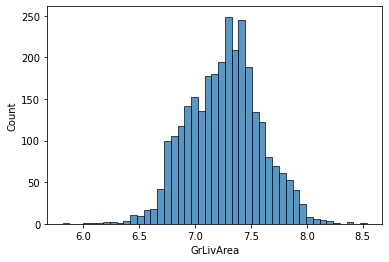

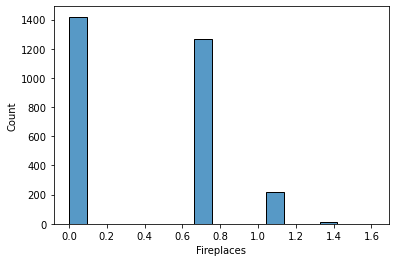

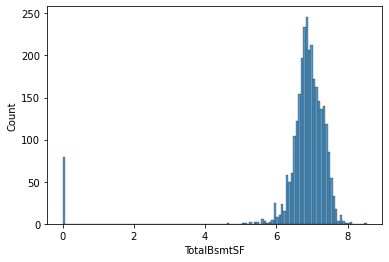

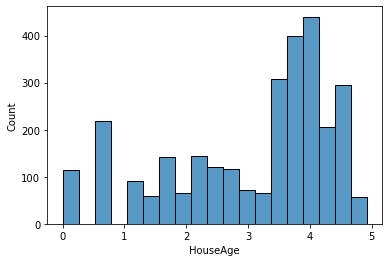

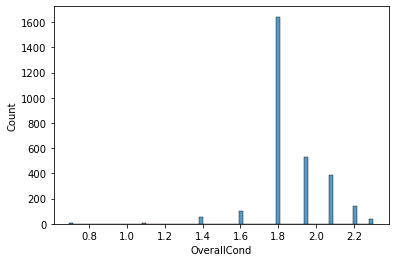

In [43]:
#Visualize the log transformation
skew_plt = list(high_skew.index)    
for i in skew_plt:    
    fig, ax=plt.subplots()
    sns.histplot(combined[i])

In [44]:
# Mapping some ordinal categorical variables that contain information in their ordering set to integers for linear models
quality = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'None' : 0}

combined = combined.replace({
    'ExterQual':quality, 'ExterCond':quality,
    'BsmtQual':quality, 'BsmtCond':quality,
    'BsmtExposure':{'Gd':4, 'Av':3, 'Mn':2, 'No':1 , 'None':0},
    #Basement average rec room coded equivalent to average living quarters
    'BsmtFinType1':{'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'None':0},
    'BsmtFinType2':{'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'None':0},
    'HeatingQC': quality,
    'CentralAir': {'N':0, 'Y':1},
    'KitchenQual': quality,
    'Functional':{'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0},
    'FireplaceQu' : quality,
    'GarageFinish':{'Fin':3, 'RFn':2, 'Unf':1, 'None':0},
    'GarageQual':quality, 'GarageCond' :quality,
    'PavedDrive':{'Y':2, 'P':1, 'N':0},
    'PoolQC': quality,
    'Fence':{'GdPrv':2,'MnPrv':1,'GdWo':2,'MnWw':1,'None':0}
})

combined.shape

(2917, 62)

<ipython-input-45-3ff782968ab4>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax = plt.subplots()


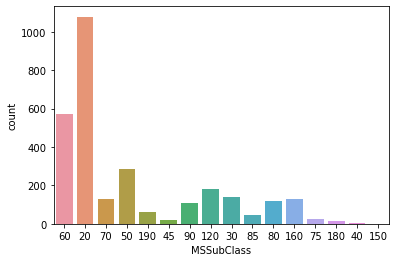

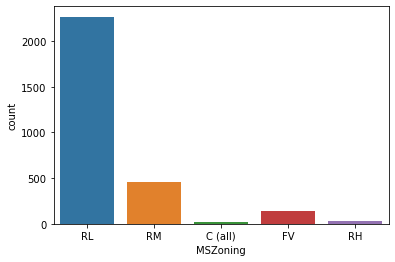

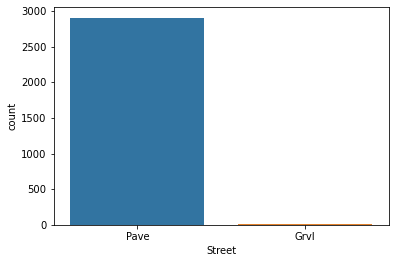

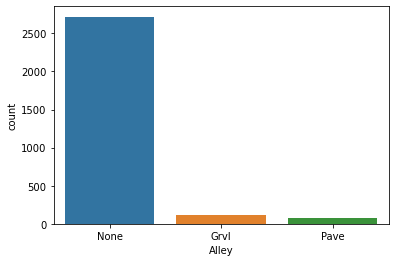

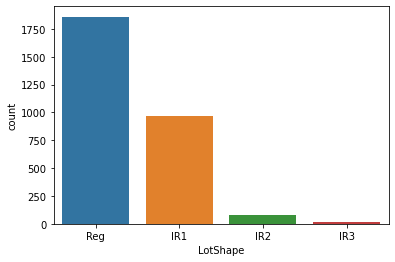

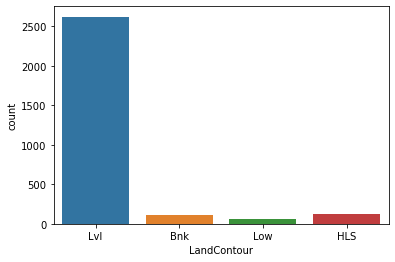

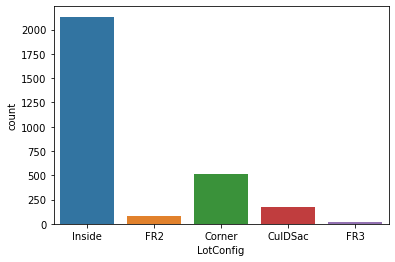

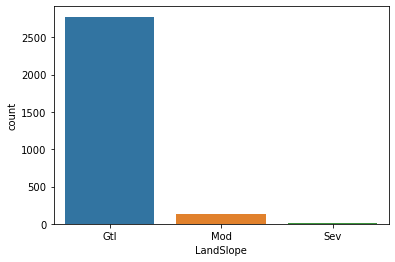

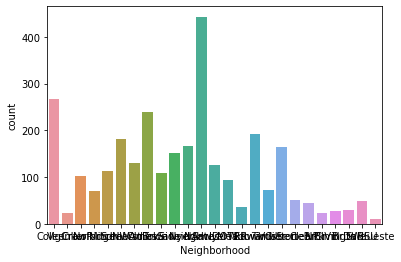

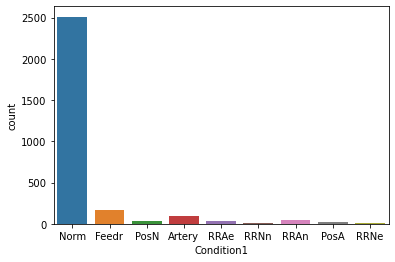

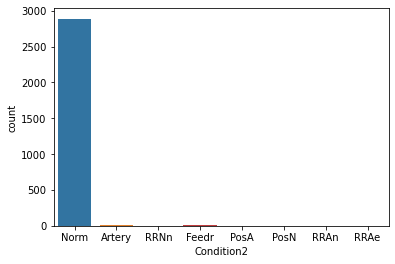

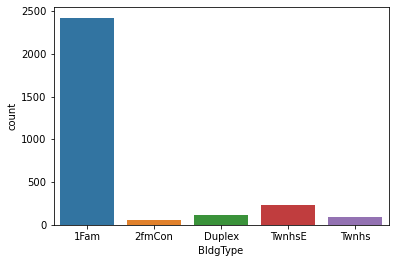

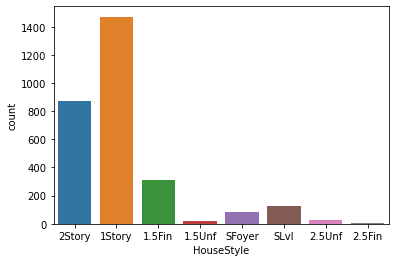

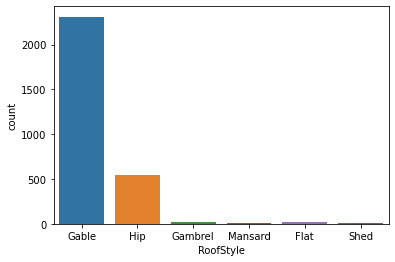

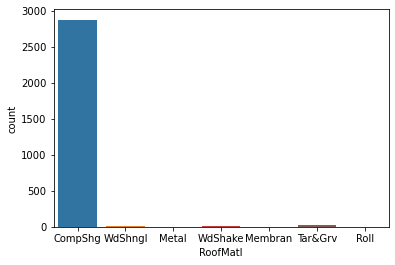

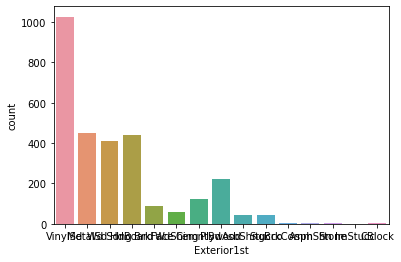

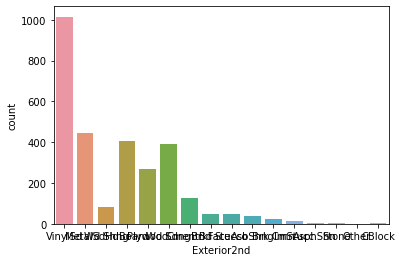

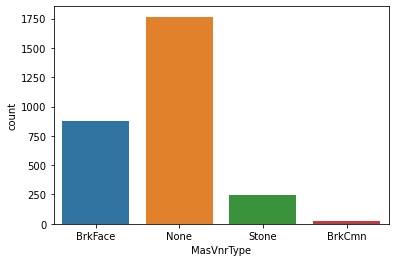

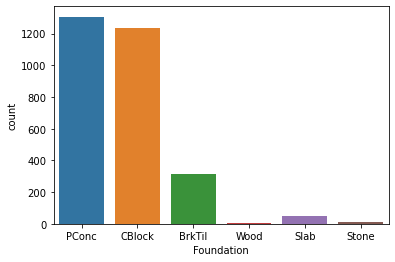

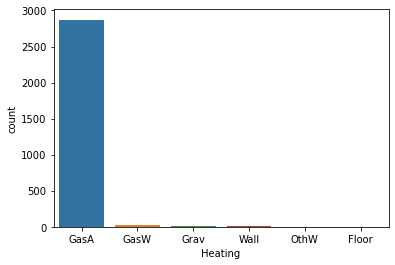

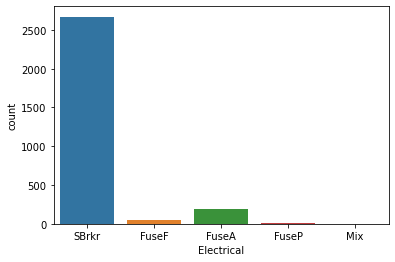

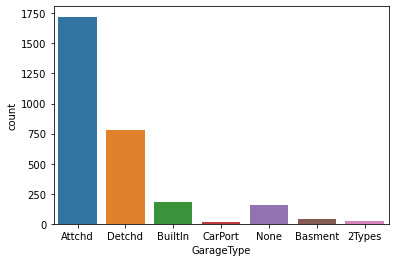

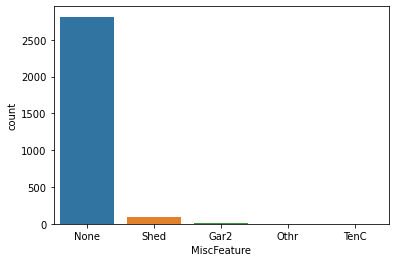

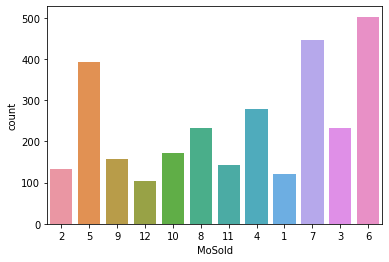

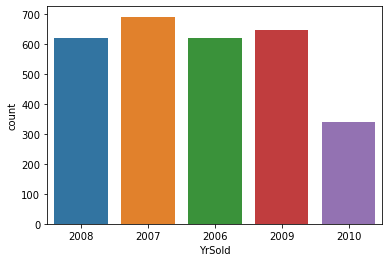

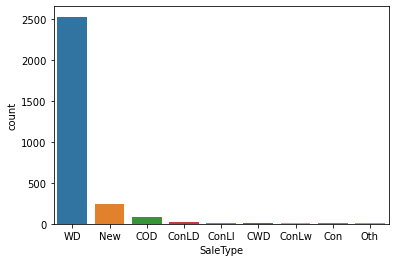

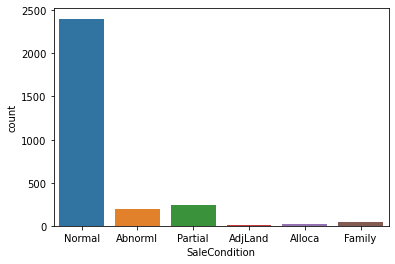

In [45]:
#Before dummifying the remaining categorical variables, review what's left and see if any can be dropped
cat_cols = list(combined.select_dtypes('O').columns)
cat_cols

for i in cat_cols:    
    ax = plt.subplots()
    sns.countplot(x=combined[i], data=combined)
#based on these plots, drop Alley, Heating (already have HeatingQC), MiscFeature (related to MiscVal), Condition2

In [48]:
combined = combined.drop(columns=['Alley','Heating','MiscFeature','Condition2'])
combined.shape

(2917, 58)

In [49]:
#Dummify remaining categorical variables for linear models (non-ordinal)
combined2 = combined.copy()
combined2 = pd.get_dummies(combined)
combined2.shape

(2917, 219)

In [174]:
#Re-split data into train and test
y = train['SalePrice']

x_train = combined2[:len(y)]
x_test = combined2[len(y):]

x_train_cat = combined[:len(y)]
x_test_cat = combined[len(y):]

x_train.shape, x_test.shape, x_train_cat.shape, x_train_cat.shape

((1458, 219), (1459, 219), (1458, 58), (1458, 58))

In [176]:
#Split train data for training model
x_train, x_test, y_train, y_test = train_test_split(x_train, y, test_size=.30, random_state=0)
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_train_cat, y, test_size=.30, random_state=0)

In [52]:
# RMSE error measure

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, x_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [53]:
#Fit linear regression
lr = LinearRegression()
lr.fit(x_train, y_train)

print("R^2 for train set: %f" %lr.score(x_train, y_train))
print("R^2 for test set: %f" %lr.score(x_test, y_test))

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

R^2 for train set: 0.942845
R^2 for test set: 0.909976
RMSE on Training set : 0.1288430443292144
RMSE on Test set : 0.15131833437506845


In [54]:
#Ridge Regression
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print("Initial alpha :", alpha)
#Tuned further
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())

Initial alpha : 3.0
Best alpha : 4.199999999999999
Ridge RMSE on Training set : 0.1193606933512639
Ridge RMSE on Test set : 0.12675438559231691


Ridge picked 214 features and eliminated the other 5 features


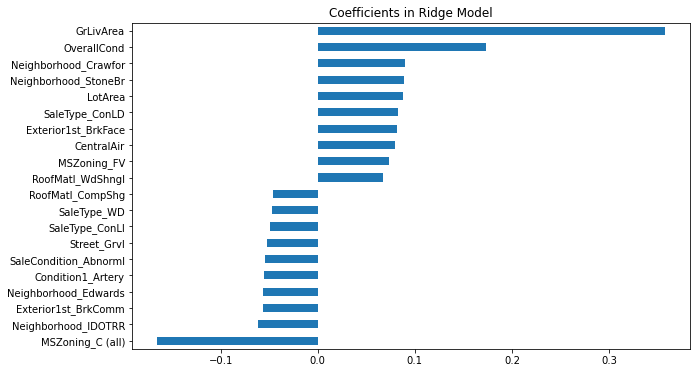

In [58]:
# Plot Ridge important coefficients
coefs = pd.Series(ridge.coef_, index = x_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
plt.figure(figsize=(10,6))
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in Ridge Model")
plt.show()

In [59]:
#Lasso Regression
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(x_train, y_train)
alpha = lasso.alpha_
print("Initial alpha :", alpha)

lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(x_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())

Initial alpha : 0.0006
Best alpha : 0.00057
Lasso RMSE on Training set : 0.11736890852306589
Lasso RMSE on Test set : 0.12011728588309575


Lasso picked 91 features and eliminated the other 128 features


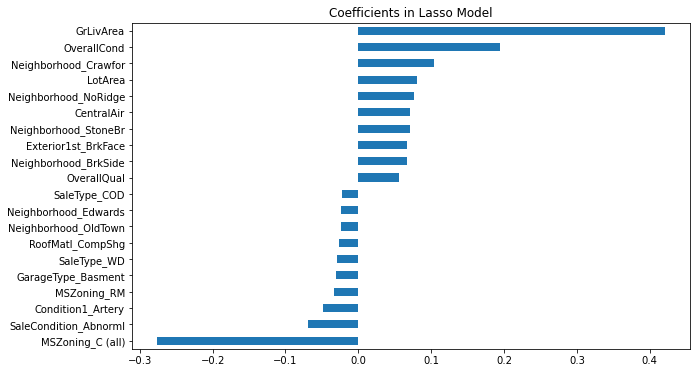

In [150]:
# Plot Lasso important coefficients
l_coefs = pd.Series(lasso.coef_, index = x_train.columns)
print("Lasso picked " + str(sum(l_coefs != 0)) + " features and eliminated the other " +  \
      str(sum(l_coefs == 0)) + " features")
imp_coefs = pd.concat([l_coefs.sort_values().head(10),
                     l_coefs.sort_values().tail(10)])
plt.figure(figsize=(10,6))
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in Lasso Model")
plt.show()

In [159]:
imp_coefs

MSZoning_C (all)        -0.275837
SaleCondition_Abnorml   -0.069119
Condition1_Artery       -0.048604
MSZoning_RM             -0.033262
GarageType_Basment      -0.031024
SaleType_WD             -0.029887
RoofMatl_CompShg        -0.026140
Neighborhood_OldTown    -0.023701
Neighborhood_Edwards    -0.023366
SaleType_COD            -0.022455
OverallQual              0.056139
Neighborhood_BrkSide     0.066714
Exterior1st_BrkFace      0.066716
Neighborhood_StoneBr     0.070858
CentralAir               0.071331
Neighborhood_NoRidge     0.076130
LotArea                  0.079890
Neighborhood_Crawfor     0.103490
OverallCond              0.194033
GrLivArea                0.420255
dtype: float64

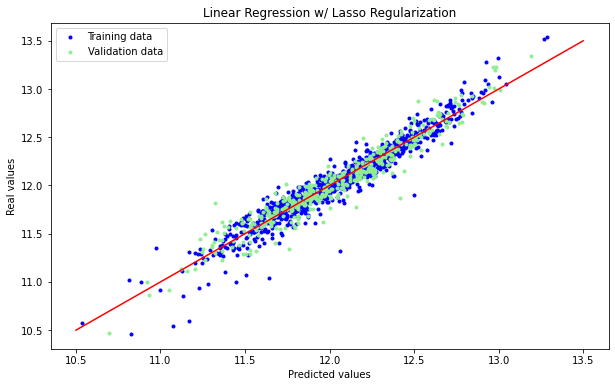

In [130]:
# Plot Lasso predictions
plt.figure(figsize=(10,6))
plt.scatter(predicted_train, y_train, c = "blue", marker = ".", label = "Training data")
plt.scatter(predicted_test, y_test, c = "lightgreen", marker = ".", label = "Validation data")
plt.title("Linear Regression w/ Lasso Regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

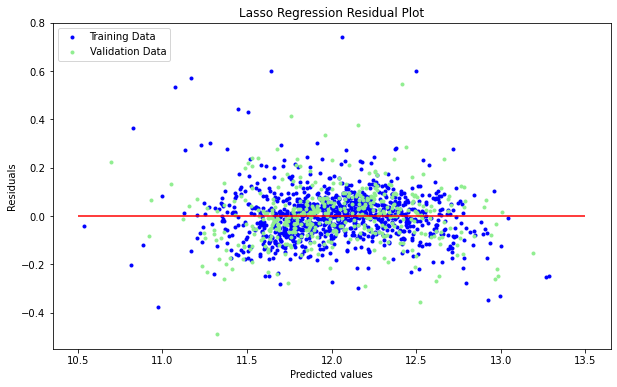

In [164]:
# Plot residuals
plt.figure(figsize=(10,6))
plt.scatter(predicted_train, predicted_train - y_train, c = "blue", marker = ".", label = "Training Data")
plt.scatter(predicted_test, predicted_test - y_test, c = "lightgreen", marker = ".", label = "Validation Data")
plt.title("Lasso Regression Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

In [88]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
enet.fit(x_train, y_train)

alpha = enet.alpha_
ratio = enet.l1_ratio_
print("Initial l1_ratio :", ratio)
print("Initial alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
enet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
enet.fit(x_train, y_train)
if (enet.l1_ratio_ > 1):
    enet.l1_ratio_ = 1    
alpha = enet.alpha_
ratio = enet.l1_ratio_
print("2nd l1_ratio :", ratio)
print("2nd alpha :", alpha )

print("Try again with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
enet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
enet.fit(x_train, y_train)
if (enet.l1_ratio_ > 1):
    enet.l1_ratio_ = 1    
alpha = enet.alpha_
ratio = enet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(enet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(enet).mean())

Initial l1_ratio : 0.95
Initial alpha : 0.0006
Try again for more precision with l1_ratio centered around 0.95
2nd l1_ratio : 0.95
2nd alpha : 0.0006
Try again with l1_ratio fixed at 0.95 and alpha centered around 0.0006
Best l1_ratio : 0.95
Best alpha : 0.00057
ElasticNet RMSE on Training set : 0.11730219926028995
ElasticNet RMSE on Test set : 0.12025392747525046


Elastic Net picked 91 features and eliminated the other 128 features


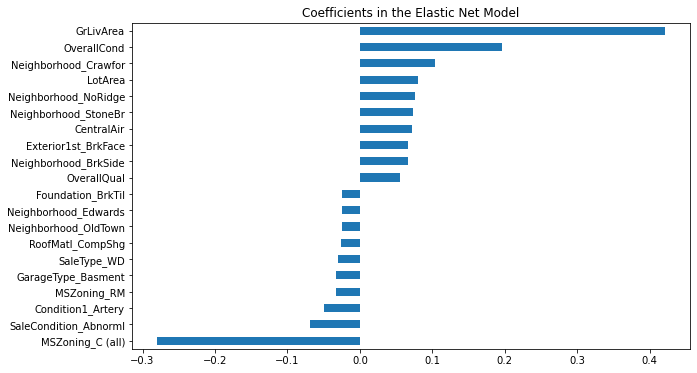

In [118]:
coefs = pd.Series(enet.coef_, index = x_train.columns)
print("Elastic Net picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")

plt.figure(figsize=(10,6))
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")
plt.show()

In [61]:
dt=DecisionTreeRegressor(random_state=100)
dt.fit(x_train,y_train)

print("The training accuracy is: %.5f" % (dt.score(x_train, y_train)))
print("The test     accuracy is: %.5f" % (dt.score(x_test, y_test)))

print(f"Random Forest RMSE on Training set: {rmse_cv_train(dt).mean()}")
print(f"Random Forest RMSE on Testing set: {rmse_cv_test(dt).mean()}")

The training accuracy is: 1.00000
The test     accuracy is: 0.75279
Random Forest RMSE on Training set: 0.23154583700377368
Random Forest RMSE on Testing set: 0.20390321358855315


In [62]:
from sklearn import ensemble

rf = ensemble.RandomForestRegressor()
rf.set_params(random_state=0)

rf.fit(x_train, y_train)

print("The training accuracy is: %.5f" % (rf.score(x_train, y_train)))
print("The test     accuracy is: %.5f" % (rf.score(x_test, y_test)))

print(f"Random Forest RMSE on Training set: {rmse_cv_train(rf).mean()}")
print(f"Random Forest RMSE on Testing set: {rmse_cv_test(rf).mean()}")

The training accuracy is: 0.98092
The test     accuracy is: 0.89720
Random Forest RMSE on Training set: 0.14404335267169194
Random Forest RMSE on Testing set: 0.14317924443210503


In [63]:
gb = GradientBoostingRegressor()
gb.fit(x_train, y_train)

print("The training accuracy is: %.5f" % (gb.score(x_train, y_train)))
print("The test     accuracy is: %.5f" % (gb.score(x_test, y_test)))

print(f"Random Forest RMSE on Training set: {rmse_cv_train(gb).mean()}")
print(f"Random Forest RMSE on Testing set: {rmse_cv_test(gb).mean()}")

The training accuracy is: 0.96689
The test     accuracy is: 0.91811
Random Forest RMSE on Training set: 0.12905410599708297
Random Forest RMSE on Testing set: 0.13636245256440352


In [104]:
#XGBoost using default parameters
import xgboost as xgb
xgb = xgb.XGBRegressor()
xgb.fit(x_train, y_train)
rmse_cv_train(xgb)
print(f"XG Boost Regression RMSE on Training set:{rmse_cv_train(xgb).mean()}")
print(f"XG Boost Regression RMSE on Testing set:{rmse_cv_test(xgb).mean()}")

XG Boost Regression RMSE on Training set:0.13904750930699372
XG Boost Regression RMSE on Testing set:0.14271547623642444


In [98]:
#Try some tuning parameters to improve XGBoost
from sklearn.model_selection import GridSearchCV

params = {'max_depth':(3, 4, 5),'n_estimators':(100,500, 1000)}
gs = GridSearchCV(xgb, params)
gs.fit(x_train, y_train)

print(gs.best_params_)

{'max_depth': 3, 'n_estimators': 1000}


In [105]:
#Re-run XGBoost
import xgboost as xgb
xgb2 = xgb.XGBRegressor(n_estimators=1000, eval_metric='rmse', max_depth=3, learning_rate=0.1)
xgb2.fit(x_train, y_train)
rmse_cv_train(xgb2)
print(f"Tuned XG Boost Regression RMSE on Training set:{rmse_cv_train(xgb2).mean()}")
print(f"Tuned XG Boost Regression RMSE on Testing set:{rmse_cv_test(xgb2).mean()}")

Tuned XG Boost Regression RMSE on Training set:0.12097297560504656
Tuned XG Boost Regression RMSE on Testing set:0.12901349420348074


[Text(0, 0.5, 'RMSE'),
 Text(0.5, 0, 'Model'),
 Text(0.5, 1.0, 'Root Mean Square Error by Model')]

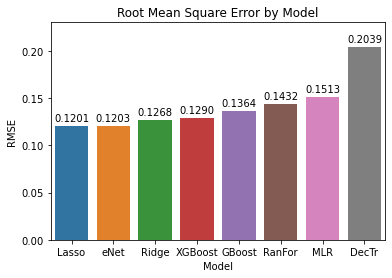

In [116]:
model_rmse = [rmse_cv_test(lasso).mean(), rmse_cv_test(enet).mean(), rmse_cv_test(ridge).mean(),rmse_cv_test(xgb2).mean(),
                rmse_cv_test(gb).mean(), rmse_cv_test(rf).mean(), rmse_cv_test(lr).mean(), rmse_cv_test(dt).mean()]
models = ['Lasso','eNet','Ridge','XGBoost','GBoost','RanFor','MLR','DecTr']

f, ax = plt.subplots()
a = sns.barplot(x=models, y=model_rmse)
for bar in a.patches:
    a.annotate(format(bar.get_height(), '.4f'), 
                   (bar.get_x() + bar.get_width()/2., bar.get_height()), 
                   ha ='center', va ='center', 
                   xytext = (0, 8), 
                   textcoords = 'offset points')
plt.ylim(0, 0.23)
ax.set(ylabel="RMSE",xlabel="Model", title="Root Mean Square Error by Model")

In [147]:
predicted = lasso.predict(x_test)
predicted_trans = np.exp(predicted)
predicted_trans

submit = pd.DataFrame()
submit['Id'] = test_ID
submit['SalePrice'] = predicted_trans
sub.to_csv('Kaggle_submit.csv',index=False)
submit

,Id,SalePrice
0,1461,121399.771523
1,1462,160681.680585
2,1463,174201.499620
3,1464,193422.208543
4,1465,191259.321145
...,...,...
1454,2915,87517.092829
1455,2916,84519.129253
1456,2917,157075.770383
1457,2918,115772.382513
